In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import processing
import runner
import matplotlib.pyplot as plt
import scipy
import plots

from scipy.signal import hilbert


/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out


# Synchronization

In a single network we want to quantify the amount of synchronization. 
In order to compare our results to Meng et al. we use phase synchronization.


### Baseline Model 

In [2]:
model = runner.run(modified_params={})

initializing net ...
initialization time: 0.15918827056884766s
------------------ running network!
runtime: 6.7


INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]


Generate PSD plot ...


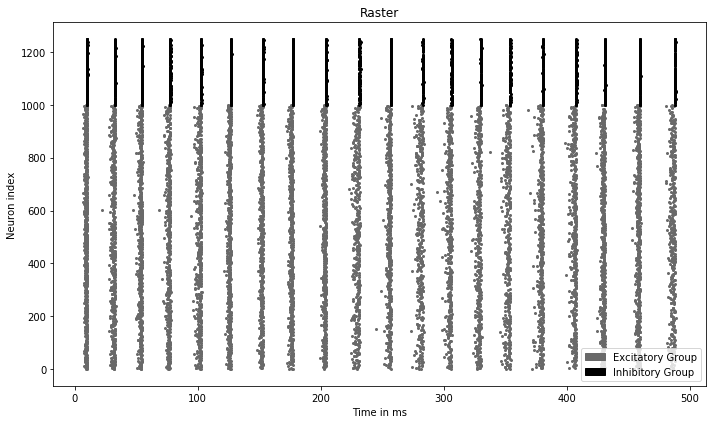

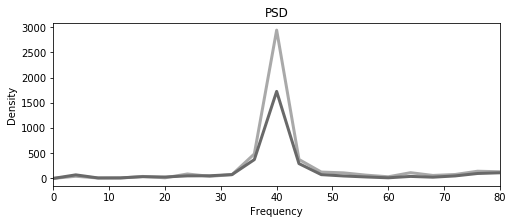

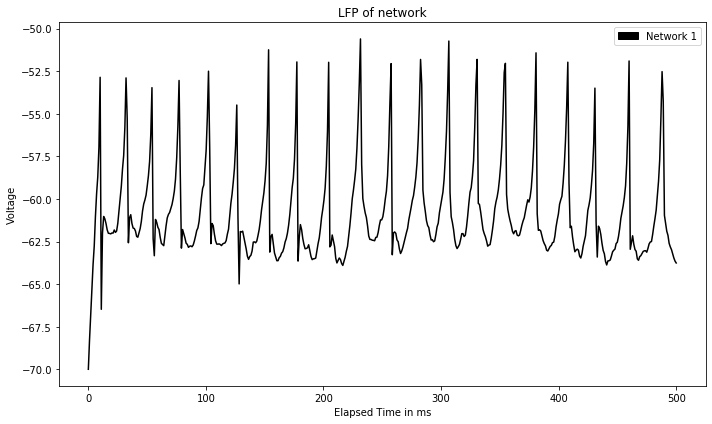

In [3]:
plots.raster(model)
plots.psd(model)
plots.lfp_nets(model, single_net=True)

In [4]:
neuron_1 = model['model_results']['net']['v_all_neurons_e'][0][:100] # only 2 neurons
neuron_2 = model['model_results']['net']['v_all_neurons_e'][1][:100] # only 2 neurons

neurons = model['model_results']['net']['v_all_neurons_e'][:100]

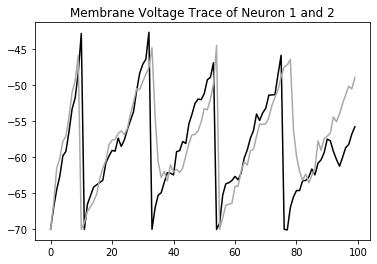

In [5]:
plt.title("Membrane Voltage Trace of Neuron 1 and 2")
plt.plot(neuron_1, c="black")
plt.plot(neuron_2, c="darkgrey")
plt.show()

### Phase Synchronization

* http://www.scholarpedia.org/article/Synchronization_measures#Phase_synchronization
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html


Phase difference (method1) of: 0.00618367152019987
Phase difference (method2) of: -0.00014487544360386017


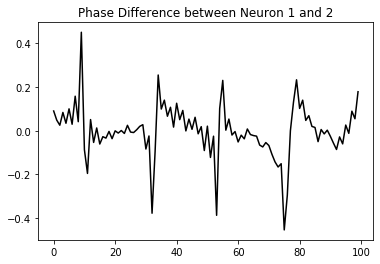

WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]


Text(0.5, 1.0, 'Instantaneous Phase')

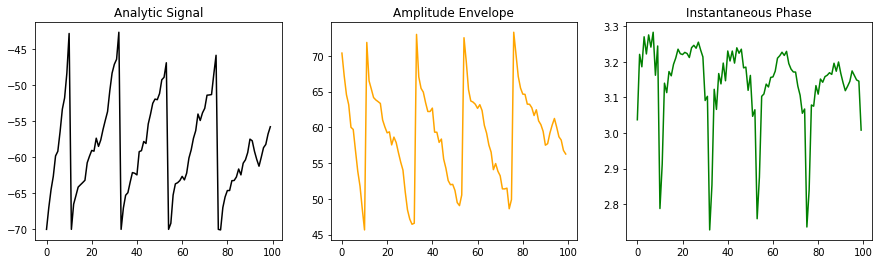

In [6]:
phase = processing.hilphase(neuron_1, neuron_2)
print("Phase difference (method1) of:", phase)

phase_diff, avg_phase = processing.hilphase_2(neuron_1, neuron_2)
print("Phase difference (method2) of:", avg_phase)

plt.title("Phase Difference between Neuron 1 and 2")
plt.plot(phase_diff, c="black")
plt.show()

analytic_signal = hilbert(neuron_1)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(analytic_signal, c='black')
axs[0].set_title("Analytic Signal")

axs[1].plot(amplitude_envelope, c='orange')
axs[1].set_title("Amplitude Envelope")

axs[2].plot(instantaneous_phase, c='green')
axs[2].set_title("Instantaneous Phase")


### Cross Correlate

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

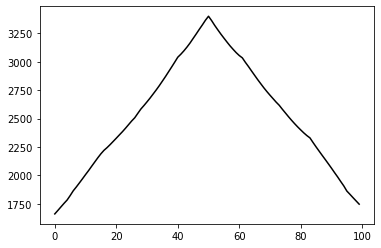

In [7]:
correlate = scipy.signal.correlate(neuron_1, neuron_2, mode='same') / neuron_1.shape[0]
plt.plot(correlate, c="black")

### Coherence

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html

WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  .format(nperseg, input_length))
 [py.warnings]


Text(0, 0.5, 'Coherence')

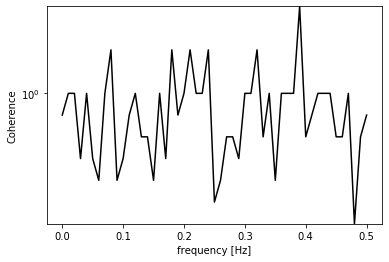

In [8]:
f, Cxy = scipy.signal.coherence(neuron_1, neuron_2)
plt.semilogy(f, Cxy, c="black")
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')


### Local Order Parameter

We want to calculate the local order parameter as used in Meng et al. 2018 to measure synchronization within a network.
It is defined as the average phase of the neurons in a network. Each neuron corresponds to an oscillator. We get the phase of an oscillator by computing the analyticsl signal using the Hilbert transform.

Order parameter:

* $ r(t)e^{i\psi(t)} = \frac{1}{N} \sum^{N}_{\alpha = 1} e^{i\psi_k^{\alpha}(t)} $

[2.97963489 3.16293469 3.1407398  3.22023078 3.18229698 3.23015255
 3.20545053 3.23879221 3.12796374 3.20047033]
[170.7205036104835, 177.46342081425104, 178.25277565845013, 179.1881252526693, 176.72070498978235, 175.95058420517827, 177.74393606624534, 178.5510215687135, 173.1184830521198, 179.038570525741]
Local order of 1.57063463594672


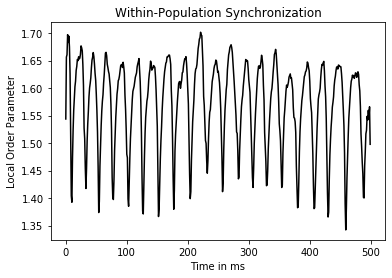

In [9]:
phases = [processing.phase(neuron) for neuron in neurons]

print(phases[0][:10])
print([np.degrees(phase)[0] for phase in phases[:10]])

# average of each time step
avg_phase = np.average(phases, axis=0)

plt.title("Within-Population Synchronization")
plt.xlabel("Time in ms")
plt.ylabel("Local Order Parameter")

plt.plot(avg_phase, c="black")

# TODO: probably cannot simply take average of phase, have to convert it to complex repres. and then average it?
print(f"Local order of {np.average(avg_phase)}")

### Phase Distribution and PLV

Below the distribution of the average phase of a neuron is shown.
The population is fairly synchronized as can be seen in the raster plot at the top.
Therefore, the distribution is also narrow. 


TODO: check whether 180 degree is really correct. 


PLV of excitatorry group 0.2227093600441439


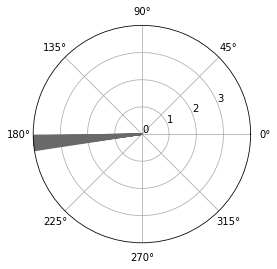

In [10]:
plv = processing.phase_locking_value(neurons)
print(f"PLV of excitatorry group {plv}")

phases = [processing.phase(neuron) for neuron in neurons]

plt.axes(polar=True)
plt.ylim(0, 4)
plt.yticks(np.arange(0, 4 , 1.0))
for angle in phases:
    # TODO: calculate average across time for each neuron!
    
    # only angle matters, therefore we set constant radius
    plt.plot((0, angle[1]), (0, 4), c="dimgrey")
plt.show()

# TODO: plot avg phase parameter over time!
# TODO: plot avg phase difference over time?
# TODO: try some model configuration that are highly desynchronized and highly synchronized to analyze behavior of order parameter